In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
train_dir = '/kaggle/input/tomatoleaf/tomato/train/'
test_dir = '/kaggle/input/tomatoleaf/tomato/val/'

SPECIES=[
'Tomato___Late_blight',
 'Tomato___healthy',
 'Tomato___Early_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Leaf_Mold',
 'Tomato___Spider_mites Two-spotted_spider_mite'
]


In [3]:
os.listdir(train_dir)

['Tomato___Late_blight',
 'Tomato___healthy',
 'Tomato___Early_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Leaf_Mold',
 'Tomato___Spider_mites Two-spotted_spider_mite']

In [4]:
for species in SPECIES:
    print('{} {} images'.format(species, len(os.listdir(os.path.join(train_dir, species)))))

Tomato___Late_blight 1000 images
Tomato___healthy 1000 images
Tomato___Early_blight 1000 images
Tomato___Septoria_leaf_spot 1000 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus 1000 images
Tomato___Bacterial_spot 1000 images
Tomato___Target_Spot 1000 images
Tomato___Tomato_mosaic_virus 1000 images
Tomato___Leaf_Mold 1000 images
Tomato___Spider_mites Two-spotted_spider_mite 1000 images


In [5]:
train = []

for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append(['/kaggle/input/tomatoleaf/tomato/train/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)

Training Data:  (10000, 3)


In [6]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [7]:
%%time

x_train = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_train = np.array(x_train)

CPU times: user 1min 53s, sys: 6.51 s, total: 2min
Wall time: 1min 55s


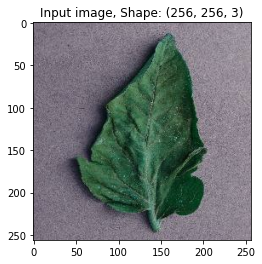

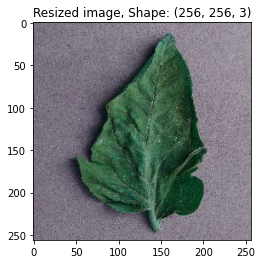

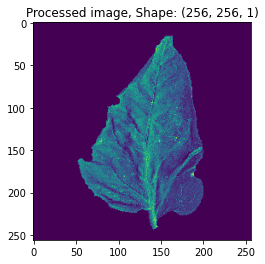

In [8]:
# Input image
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(256,256)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()       

In [9]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10)

In [11]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (256, 256, 4)


In [12]:
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16)

x = fire_incept(x, fire=32, intercept=32)
x = fire_squeeze(x, fire=32, intercept=32)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

out = Dense(len(SPECIES), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 126, 16) 1616        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 126, 126, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 126, 126, 16) 2320        leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [13]:
model_new.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy'])


In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)

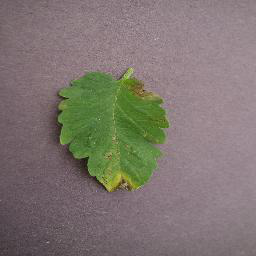

In [15]:
from keras.preprocessing.image import load_img
load_img("../input/tomatoleaf/tomato/val/Tomato___Late_blight/01c391d2-1b3a-4b58-b205-a75674bba6e9___GHLB2 Leaf 8824.JPG")

In [16]:
%%time

test = []
for file in os.listdir(os.path.join(test_dir, species)):
        test.append(['/kaggle/input/tomatoleaf/tomato/val/{}/{}'.format(species, file), species_num, species])

test = pd.DataFrame(test, columns=['file', 'species_num', 'species'])
print(test.head(5))


x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_test = np.array(x_test)


                                                file  species_num  \
0  /kaggle/input/tomatoleaf/tomato/val/Tomato___S...            9   
1  /kaggle/input/tomatoleaf/tomato/val/Tomato___S...            9   
2  /kaggle/input/tomatoleaf/tomato/val/Tomato___S...            9   
3  /kaggle/input/tomatoleaf/tomato/val/Tomato___S...            9   
4  /kaggle/input/tomatoleaf/tomato/val/Tomato___S...            9   

                                         species  
0  Tomato___Spider_mites Two-spotted_spider_mite  
1  Tomato___Spider_mites Two-spotted_spider_mite  
2  Tomato___Spider_mites Two-spotted_spider_mite  
3  Tomato___Spider_mites Two-spotted_spider_mite  
4  Tomato___Spider_mites Two-spotted_spider_mite  
CPU times: user 1.15 s, sys: 40.5 ms, total: 1.19 s
Wall time: 966 ms


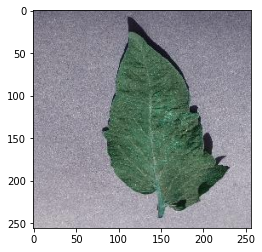

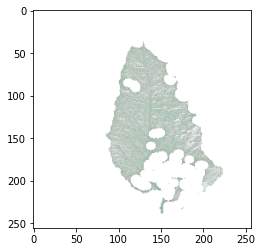

In [17]:
randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

img_processed = x_test[randm]
plt.imshow(img_processed)
plt.show()

In [18]:
score = model_new.evaluate(x_val,y_val)
print('Accuracy on Validation Set',score[1])

1000/1000 [==============================] - 22s 22ms/step
Accuracy on Validation Set 0.09700000286102295


In [19]:
Pred_labels = np.argmax(model_new.predict(x_test),axis = 1)

In [20]:
Pred_labels

array([8, 4, 8, 5, 5, 8, 4, 8, 4, 0, 4, 4, 4, 4, 8, 8, 4, 5, 8, 8, 8, 8,
       4, 4, 4, 8, 4, 4, 8, 8, 8, 5, 4, 5, 7, 8, 4, 5, 5, 4, 8, 5, 8, 4,
       4, 4, 4, 0, 8, 5, 8, 4, 4, 4, 8, 0, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4,
       5, 4, 8, 4, 5, 4, 8, 4, 8, 5, 5, 5, 5, 4, 4, 4, 5, 4, 4, 5, 5, 4,
       0, 4, 5, 4, 0, 5, 5, 4, 8, 8, 4, 5])

In [21]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

In [22]:
test_id

,file
0,Tomato___Late_blight
1,Tomato___healthy
2,Tomato___Early_blight
3,Tomato___Septoria_leaf_spot
4,Tomato___Tomato_Yellow_Leaf_Curl_Virus
5,Tomato___Bacterial_spot
6,Tomato___Target_Spot
7,Tomato___Tomato_mosaic_virus
8,Tomato___Leaf_Mold
9,Tomato___Spider_mites Two-spotted_spider_mite


In [23]:
model_feat = Model(inputs=model_new.input,outputs=model_new.get_layer('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)


(9000, 512)
(1000, 512)
(100, 512)


In [24]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


In [25]:
svm.score(feat_train,np.argmax(y_train,axis=1))


0.6193333333333333

In [26]:
svm.score(feat_val,np.argmax(y_val,axis=1))


0.564

In [27]:
import xgboost as xgb

xb = xgb.XGBClassifier()

xb.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


In [28]:
xb.score(feat_train,np.argmax(y_train,axis=1))

1.0

In [29]:
xb.score(feat_val,np.argmax(y_val,axis=1))

0.554